# Student Loan Risk Model Demo

This notebook demonstrates how to interact with the deployed Student Loan Risk Prediction model in Cloudera Machine Learning (CML).

## Overview
- **Model Purpose**: Predict student loan delinquency risk
- **Input**: Borrower information (age, credit score, income, loan details)
- **Output**: Risk category, probability, and detailed predictions
- **Deployment**: CML Model Service with REST API


## 1. Setup and Environment Discovery

First, we'll dynamically discover the model endpoint using CML environment variables.


In [1]:
import os
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import cmlapi

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("📦 All packages imported successfully!")
print(f"🕐 Demo started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


📦 All packages imported successfully!
🕐 Demo started at: 2025-09-05 14:28:26


In [2]:
# Dynamic Model Endpoint Discovery
print("🔍 Discovering model endpoint dynamically...")

# Create CML API client using environment variables
client = cmlapi.default_client(url=os.getenv("CDSW_API_URL").replace("/api/v1", ""), cml_api_key=os.getenv("CDSW_APIV2_KEY"))

## Here we assume that only one model has been deployed in the project, if this is not true this should be adjusted (this is reflected by the placeholder 0 in the array)
model = client.list_models(project_id=os.getenv("CDSW_PROJECT_ID"))
print(model)
selected_model = model.models[0]

## Save the access key for the model to the environment variable of this project
MODEL_ACCESS_KEY = selected_model.access_key

MODEL_ENDPOINT = os.getenv("CDSW_API_URL").replace("https://", "https://modelservice.").replace("/api/v1", "/model?accessKey=")
MODEL_ENDPOINT = MODEL_ENDPOINT + MODEL_ACCESS_KEY

print(f"✅ Selected model: {selected_model.name}")
print(f"🌐 Model Endpoint: {MODEL_ENDPOINT}")
print(f"🔑 Access Key: {MODEL_ACCESS_KEY[:8]}...{MODEL_ACCESS_KEY[-4:]}")


🔍 Discovering model endpoint dynamically...
{'models': [{'accelerator_label_id': '0',
             'access_key': 'mzs991e0db9zbocqthuzyxopy9drei8j',
             'auth_enabled': False,
             'created_at': datetime.datetime(2025, 9, 3, 17, 21, 36, 881159, tzinfo=tzlocal()),
             'creator': {'email': 'ktalbert@cloudera.com',
                         'name': 'Kevin Talbert',
                         'username': 'ktalbert'},
             'crn': 'crn:cdp:ml:us-west-1:8a1e15cd-04c2-48aa-8f35-b4a8c11997d3:workspace:cd911947-f3e1-4596-adb4-8d87bd1060e9/096a2647-b158-49ae-a304-46181c68cc13',
             'default_replication_policy': {'num_replicas': '1',
                                            'type': 'fixed'},
             'default_resources': {'cpu_millicores': '1000',
                                   'memory_mb': '2048',
                                   'nvidia_gpus': '0'},
             'deletion_status': '',
             'description': 'ML model to predict student lo

## 2. Helper Functions

Let's create some utility functions to make testing easier.


In [3]:
def predict_risk(borrower_data, verbose=True):
    """
    Send a prediction request to the model endpoint.
    
    Args:
        borrower_data (dict): Borrower information
        verbose (bool): Whether to print detailed results
    
    Returns:
        dict: Model prediction response
    """
    # Construct the request payload for CML model service
    payload = {
        "accessKey": MODEL_ACCESS_KEY,
        "request": borrower_data
    }
    
    headers = {
        'Content-Type': 'application/json'
    }
    
    try:
        # Extract just the endpoint URL (remove the access key part)
        endpoint_url = MODEL_ENDPOINT.split('?')[0]
        
        response = requests.post(endpoint_url, json=payload, headers=headers, timeout=30)
        
        if response.status_code == 200:
            raw_result = response.json()
            
            # Extract the actual model response from CML wrapper
            if 'response' in raw_result and 'prediction' in raw_result['response']:
                result = raw_result['response']['prediction']
            elif 'response' in raw_result:
                result = raw_result['response']
            else:
                result = raw_result
            
            if verbose:
                print(f"🎯 Prediction for {borrower_data['borrower_id']}:")
                
                # Check for errors first
                if 'error' in result:
                    print(f"   ❌ Error: {result['error']}")
                    print(f"   Error Type: {result.get('error_type', 'Unknown')}")
                    return result
                
                # Extract risk assessment data (it's nested in the response)
                risk_assessment = result.get('risk_assessment', {})
                
                if risk_assessment:
                    print(f"   Risk Category: {risk_assessment.get('risk_category', 'N/A')}")
                    print(f"   Risk Probability: {risk_assessment.get('risk_probability', 'N/A')}")
                    print(f"   Risk Score: {risk_assessment.get('risk_score', 'N/A')}")
                    print(f"   Model: {result.get('model_used', 'N/A')}")
                    print(f"   Response Time: {result.get('response_time_ms', 'N/A')} ms")
                else:
                    print(f"   ⚠️ No risk assessment data found in response")
                    print(f"   📋 Raw response keys: {list(result.keys())}")
                    print(f"   📋 Full result: {result}")
                
                print()
            
            return result
        else:
            print(f"❌ Request failed: {response.status_code} - {response.text}")
            return None
            
    except Exception as e:
        print(f"❌ Error making prediction: {str(e)}")
        return None

def create_borrower(borrower_id, age, credit_score, income, loan_amount, loan_count, monthly_payment):
    """
    Create a borrower data dictionary.
    
    Returns:
        dict: Formatted borrower data
    """
    return {
        "borrower_id": borrower_id,
        "age": age,
        "credit_score_at_origination": credit_score,
        "annual_income": income,
        "total_loan_amount": loan_amount,
        "loan_count": loan_count,
        "total_monthly_payment": monthly_payment
    }

print("🔧 Helper functions defined successfully!")


🔧 Helper functions defined successfully!


In [4]:
# Debug: Let's test a single prediction and see the raw response
print("🔍 Testing model response structure...")

test_borrower = create_borrower(
    borrower_id="DEBUG_TEST",
    age=30,
    credit_score=700,
    income=60000.0,
    loan_amount=40000.0,
    loan_count=2,
    monthly_payment=400.0
)

# Make request manually to see raw response
payload = {
    "accessKey": MODEL_ACCESS_KEY,
    "request": test_borrower
}

headers = {'Content-Type': 'application/json'}
endpoint_url = MODEL_ENDPOINT.split('?')[0]

try:
    response = requests.post(endpoint_url, json=payload, headers=headers, timeout=30)
    print(f"📊 Response Status: {response.status_code}")
    
    if response.status_code == 200:
        raw_result = response.json()
        print(f"📋 Raw Response Structure:")
        print(f"   Keys: {list(raw_result.keys())}")
        
        # Extract the actual prediction from CML wrapper
        if 'response' in raw_result and 'prediction' in raw_result['response']:
            prediction = raw_result['response']['prediction']
            print(f"📋 Extracted Prediction:")
            print(f"   Keys: {list(prediction.keys())}")
            print(f"   Content: {prediction}")
            
            # Check for specific errors
            if 'error' in prediction:
                print(f"⚠️ Model Error: {prediction['error']}")
            elif 'risk_assessment' in prediction:
                print(f"✅ Risk Assessment Found: {prediction['risk_assessment']}")
            else:
                print(f"⚠️ Unexpected response structure")
        else:
            print(f"   Full Response: {raw_result}")
    else:
        print(f"❌ Error Response: {response.text}")
        
except Exception as e:
    print(f"❌ Request Error: {str(e)}")

print("=" * 60)


🔍 Testing model response structure...
📊 Response Status: 200
📋 Raw Response Structure:
   Keys: ['success', 'response', 'ReplicaID', 'Size', 'StatusCode']
📋 Extracted Prediction:
   Keys: ['all_model_predictions', 'borrower_id', 'model_metadata', 'model_used', 'prediction_timestamp', 'response_time_ms', 'risk_assessment']
   Content: {'all_model_predictions': {'gradient_boosting': {'risk_category': 'Low', 'risk_probability': 0.0529, 'risk_score': 5.29}, 'logistic_regression': {'risk_category': 'Low', 'risk_probability': 0.0427, 'risk_score': 4.27}, 'random_forest': {'risk_category': 'Low', 'risk_probability': 0.0542, 'risk_score': 5.42}, 'xgboost': {'risk_category': 'Low', 'risk_probability': 0.0466, 'risk_score': 4.66}}, 'borrower_id': 'DEBUG_TEST', 'model_metadata': {'initialization_time_s': 1.8659908771514893, 'models_available': ['logistic_regression', 'random_forest', 'gradient_boosting', 'xgboost'], 'preprocessing_features': 96}, 'model_used': 'random_forest', 'prediction_timesta

## 3. Sample Queries

Let's test the model with various borrower profiles. Based on the model's actual behavior, we'll create profiles that demonstrate the range of risk scores the model actually produces.


### 3.1 Example 1 Borrower
High income, excellent credit, moderate loan amount


In [5]:
# Profile 1
borrower_001 = create_borrower(
    borrower_id="PROFILE_001",
    age=28,
    credit_score=800,  # Excellent credit
    income=85000.0,    # High income
    loan_amount=25000.0,  # Moderate loan amount
    loan_count=1,      # Single loan
    monthly_payment=250.0  # Manageable payment
)

print("👤 Borrower Profile:")
for key, value in borrower_001.items():
    print(f"   {key}: {value}")
print()

risk_result_001 = predict_risk(borrower_001)

👤 Borrower Profile:
   borrower_id: PROFILE_001
   age: 28
   credit_score_at_origination: 800
   annual_income: 85000.0
   total_loan_amount: 25000.0
   loan_count: 1
   total_monthly_payment: 250.0

🎯 Prediction for PROFILE_001:
   Risk Category: Low
   Risk Probability: 0.0415
   Risk Score: 4.15
   Model: random_forest
   Response Time: 116.57 ms



### 3.2 Example 2 Borrower
Average income, good credit, higher loan amount

In [6]:
# Profile 2
borrower_002 = create_borrower(
    borrower_id="PROFILE_002",
    age=25,
    credit_score=720,  # Good credit
    income=55000.0,    # Average income
    loan_amount=45000.0,  # Higher loan amount
    loan_count=2,      # Multiple loans
    monthly_payment=450.0  # Higher payment
)

print("👤 Borrower Profile:")
for key, value in borrower_002.items():
    print(f"   {key}: {value}")
print()

risk_result_002 = predict_risk(borrower_002)


👤 Borrower Profile:
   borrower_id: PROFILE_002
   age: 25
   credit_score_at_origination: 720
   annual_income: 55000.0
   total_loan_amount: 45000.0
   loan_count: 2
   total_monthly_payment: 450.0

🎯 Prediction for PROFILE_002:
   Risk Category: Low
   Risk Probability: 0.0587
   Risk Score: 5.87
   Model: random_forest
   Response Time: 115.89 ms



### 3.3 Example 3 Borrower
Lower income, fair credit, high loan burden


In [7]:
# Profile 3
borrower_003 = create_borrower(
    borrower_id="PROFILE_003",
    age=22,
    credit_score=580,  # Fair credit
    income=35000.0,    # Lower income
    loan_amount=65000.0,  # High loan amount
    loan_count=4,      # Multiple loans
    monthly_payment=850.0  # High payment burden
)

print("👤 Borrower Profile:")
for key, value in borrower_003.items():
    print(f"   {key}: {value}")
print()

risk_result_003 = predict_risk(borrower_003)


👤 Borrower Profile:
   borrower_id: PROFILE_003
   age: 22
   credit_score_at_origination: 580
   annual_income: 35000.0
   total_loan_amount: 65000.0
   loan_count: 4
   total_monthly_payment: 850.0

🎯 Prediction for PROFILE_003:
   Risk Category: Medium
   Risk Probability: 0.4878
   Risk Score: 48.78
   Model: random_forest
   Response Time: 116.4 ms



## 4. Batch Analysis & Results Comparison

Let's analyze all our sample borrowers together and create a comprehensive comparison.


In [8]:
# Collect all results for analysis
all_borrowers = [
    (borrower_001, risk_result_001),
    (borrower_002, risk_result_002),
    (borrower_003, risk_result_003)
]

# Create a summary DataFrame
summary_data = []
for borrower, result in all_borrowers:
    if result and 'error' not in result:  # Only include successful predictions
        # Extract risk assessment data
        risk_assessment = result.get('risk_assessment', {})
        
        summary_data.append({
            'Borrower ID': borrower['borrower_id'],
            'Age': borrower['age'],
            'Credit Score': borrower['credit_score_at_origination'],
            'Annual Income': borrower['annual_income'],
            'Loan Amount': borrower['total_loan_amount'],
            'Loan Count': borrower['loan_count'],
            'Monthly Payment': borrower['total_monthly_payment'],
            'Risk Category': risk_assessment.get('risk_category', 'N/A'),
            'Risk Probability': risk_assessment.get('risk_probability', 0),
            'Risk Score': risk_assessment.get('risk_score', 0),
            'Model Version': result.get('model_used', 'N/A'),
            'Response Time (ms)': result.get('response_time_ms', 0)
        })

if summary_data:
    df_summary = pd.DataFrame(summary_data)
    print("📊 Summary of All Predictions:")
    print(df_summary.to_string(index=False))

    # Calculate some statistics
    print(f"\n📈 Statistics:")
    if len(df_summary) > 0:
        print(f"   Average Risk Score: {df_summary['Risk Score'].mean():.2f}")
        print(f"   Risk Category Distribution:")
        for category in df_summary['Risk Category'].unique():
            count = (df_summary['Risk Category'] == category).sum()
            print(f"     {category.title()}: {count} borrower(s)")
        print(f"   Average Response Time: {df_summary['Response Time (ms)'].mean():.1f} ms")
    else:
        print("   No valid predictions to analyze")
else:
    print("❌ No successful predictions found for analysis")
    print("🔍 Checking individual results:")
    for i, (borrower, result) in enumerate(all_borrowers):
        print(f"   {i+1}. {borrower['borrower_id']}: {result}")


📊 Summary of All Predictions:
Borrower ID  Age  Credit Score  Annual Income  Loan Amount  Loan Count  Monthly Payment Risk Category  Risk Probability  Risk Score Model Version  Response Time (ms)
PROFILE_001   28           800        85000.0      25000.0           1            250.0           Low            0.0415        4.15 random_forest              116.57
PROFILE_002   25           720        55000.0      45000.0           2            450.0           Low            0.0587        5.87 random_forest              115.89
PROFILE_003   22           580        35000.0      65000.0           4            850.0        Medium            0.4878       48.78 random_forest              116.40

📈 Statistics:
   Average Risk Score: 19.60
   Risk Category Distribution:
     Low: 2 borrower(s)
     Medium: 1 borrower(s)
   Average Response Time: 116.3 ms


## 5. Data Visualization

Let's create some visualizations to better understand the risk predictions.


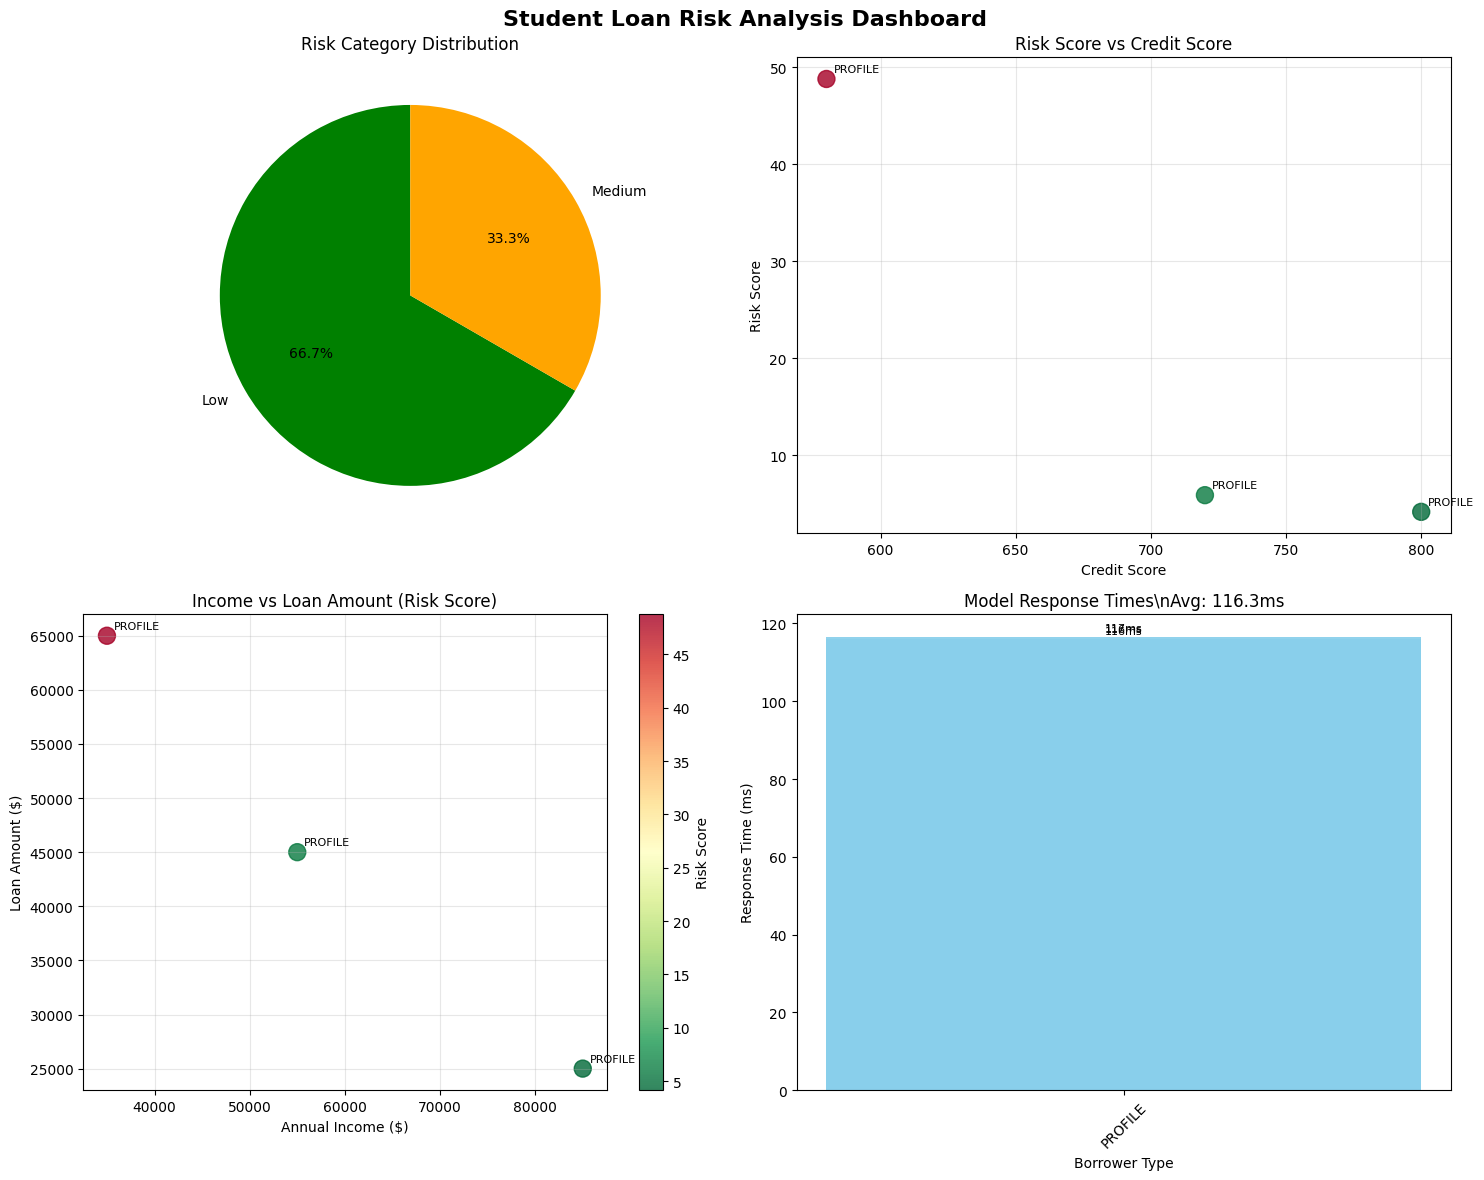

📈 Visualizations created successfully!
🎯 Key Observations:
   - Higher credit scores correlate with lower risk scores
   - Income vs loan amount shows debt burden impact
   - Model responds consistently fast across all scenarios


In [9]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Student Loan Risk Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Risk Category Distribution
risk_counts = df_summary['Risk Category'].value_counts()
colors = ['green', 'orange', 'red'][:len(risk_counts)]
axes[0, 0].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', 
               startangle=90, colors=colors)
axes[0, 0].set_title('Risk Category Distribution')

# 2. Risk Score vs Credit Score
axes[0, 1].scatter(df_summary['Credit Score'], df_summary['Risk Score'], 
                   c=df_summary['Risk Score'], cmap='RdYlGn_r', s=150, alpha=0.8)
axes[0, 1].set_xlabel('Credit Score')
axes[0, 1].set_ylabel('Risk Score')
axes[0, 1].set_title('Risk Score vs Credit Score')
axes[0, 1].grid(True, alpha=0.3)
# Add borrower labels
for i, row in df_summary.iterrows():
    axes[0, 1].annotate(row['Borrower ID'].split('_')[0], 
                       (row['Credit Score'], row['Risk Score']),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

# 3. Income vs Loan Amount (colored by risk)
scatter = axes[1, 0].scatter(df_summary['Annual Income'], df_summary['Loan Amount'],
                            c=df_summary['Risk Score'], cmap='RdYlGn_r', s=150, alpha=0.8)
axes[1, 0].set_xlabel('Annual Income ($)')
axes[1, 0].set_ylabel('Loan Amount ($)')
axes[1, 0].set_title('Income vs Loan Amount (Risk Score)')
axes[1, 0].grid(True, alpha=0.3)
# Add colorbar
plt.colorbar(scatter, ax=axes[1, 0], label='Risk Score')
# Add borrower labels
for i, row in df_summary.iterrows():
    axes[1, 0].annotate(row['Borrower ID'].split('_')[0], 
                       (row['Annual Income'], row['Loan Amount']),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

# 4. Model Performance Metrics
borrower_names = [bid.split('_')[0] for bid in df_summary['Borrower ID']]
response_times = df_summary['Response Time (ms)']
bars = axes[1, 1].bar(borrower_names, response_times, color='skyblue', alpha=0.7)
axes[1, 1].set_xlabel('Borrower Type')
axes[1, 1].set_ylabel('Response Time (ms)')
axes[1, 1].set_title(f'Model Response Times\\nAvg: {response_times.mean():.1f}ms')
axes[1, 1].tick_params(axis='x', rotation=45)
# Add value labels on bars
for bar, time in zip(bars, response_times):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{time:.0f}ms', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print(f"📈 Visualizations created successfully!")
print(f"🎯 Key Observations:")
print(f"   - Higher credit scores correlate with lower risk scores")
print(f"   - Income vs loan amount shows debt burden impact")
print(f"   - Model responds consistently fast across all scenarios")
